In [1]:
!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
import torch

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# CocoDataset
The torchvision CocoDetection dataset is currently not compatible with the official COCO format (https://cocodataset.org/#format-data), which is why we need to define a custom CocoDataset class

In [3]:
import json
from collections import defaultdict
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset

class CocoDataset(Dataset):
    """PyTorch dataset for COCO annotations."""
    # adapted from https://github.com/pytorch/vision/issues/2720

    def __init__(self, root, annFile, transform=None):
        """Load COCO annotation data."""
        self.data_dir = Path(root)
        self.transform = transform

        # load the COCO annotations json
        anno_file_path = annFile
        with open(str(anno_file_path)) as file_obj:
            self.coco_data = json.load(file_obj)
        # put all of the annos into a dict where keys are image IDs to speed up retrieval
        self.image_id_to_annos = defaultdict(list)
        for anno in self.coco_data['annotations']:
            image_id = anno['image_id']
            self.image_id_to_annos[image_id] += [anno]

    def __len__(self):
        return len(self.coco_data['images'])

    def __getitem__(self, index):
        """Return tuple of image and labels as torch tensors."""
        image_data = self.coco_data['images'][index]
        image_id = image_data['id']
        image_path = self.data_dir/image_data['file_name']
        image = Image.open(image_path)

        annos = self.image_id_to_annos[image_id]
        anno_data = {
            'boxes': [],
            'labels': [],
            'area': [],
            'iscrowd': [],
        }
        for anno in annos:
            coco_bbox = anno['bbox']
            left = coco_bbox[0]
            top = coco_bbox[1]
            right = coco_bbox[0] + coco_bbox[2]
            bottom = coco_bbox[1] + coco_bbox[3]
            area = coco_bbox[2] * coco_bbox[3]
            anno_data['boxes'].append([left, top, right, bottom])
            anno_data['labels'].append(anno['category_id'])
            anno_data['area'].append(area)
            anno_data['iscrowd'].append(anno['iscrowd'])
        

        target = {
            'boxes': torch.as_tensor(anno_data['boxes'], dtype=torch.float32),
            'labels': torch.as_tensor(anno_data['labels'], dtype=torch.int64),
            'image_id': torch.tensor([image_id]),
            'area': torch.as_tensor(anno_data['area'], dtype=torch.float32),
            'iscrowd': torch.as_tensor(anno_data['iscrowd'], dtype=torch.int64),
        }
        
        if self.transform is not None:
            image = self.transform(image)

        return image, target

## Test the dataset
I created a synthetic training and validation dataset in the COCO format using https://github.com/ignc-research/blender-gen

{'boxes': tensor([[264.7200, 186.2800, 370.4300, 298.7800]]), 'labels': tensor([1]), 'image_id': tensor([32]), 'area': tensor([11892.3750]), 'iscrowd': tensor([0])}


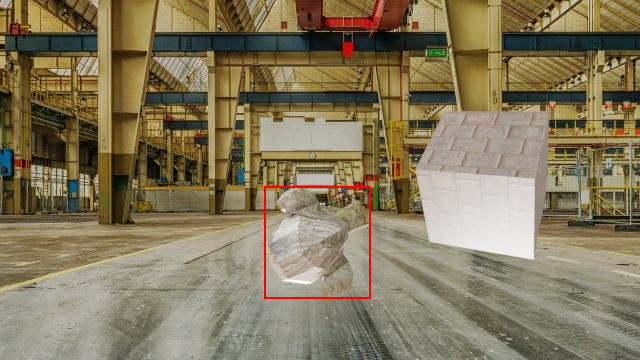

In [4]:
import torchvision.transforms as T
import random
from IPython.display import display # to display images
from PIL import ImageDraw

# create datasets
training_dataset = CocoDataset(root='./data/train/images/', annFile='./data/train/annotations/instances_default.json', transform=T.ToTensor())
validation_dataset = CocoDataset(root='./data/validation/images/', annFile='./data/validation/annotations/instances_default.json', transform=T.ToTensor())

# get a random sample
img, label = training_dataset[random.randint(0,len(training_dataset)-1)]
print(label)

# display image with bbox label
transform = T.ToPILImage()
img = transform(img)
x1, y1, x2, y2 = label['boxes'].numpy()[0]
draw = ImageDraw.Draw(img)
draw.rectangle([x1, y1, x2, y2], fill=None, outline='#ff0000cc', width=2)
display(img)

# DataLoader
The DataLoader returns batches of data during training and validation

In [5]:

def collate(batch):
    """return tuple data"""
    return tuple(zip(*batch))

BATCH_SIZE = 4
train_loader = torch.utils.data.DataLoader(
    training_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    collate_fn=collate
)

validation_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate
)

# Object Detection Model: Faster R-CNN
Choose a model from https://pytorch.org/vision/stable/models/faster_rcnn.html

In [6]:
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn, FasterRCNN_MobileNet_V3_Large_FPN_Weights

NUM_CLASSES=2 # background=0 included
def get_faster_rcnn_model(num_classes):
    model = fasterrcnn_mobilenet_v3_large_fpn(weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT)
    model.roi_heads.box_predictor.cls_score = torch.nn.Linear(in_features=model.roi_heads.box_predictor.cls_score.in_features, out_features=num_classes, bias=True)
    model.roi_heads.box_predictor.bbox_pred = torch.nn.Linear(in_features=model.roi_heads.box_predictor.bbox_pred.in_features, out_features=num_classes*4, bias=True)
    return model

model = get_faster_rcnn_model(num_classes=NUM_CLASSES)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

test the model with a validation batch as input

In [7]:
# get a validation batch
X, y = next(iter(validation_loader))

model.eval()
with torch.no_grad():
    X=[x.to(device) for x in X]
    out = model(X)
    print(out)

[{'boxes': tensor([[  0.0000,  94.3429, 144.8159, 249.5666],
        [191.2714, 165.4917, 285.0128, 204.1365],
        [118.6472,  56.5517, 126.5911,  65.4770],
        [381.0356, 273.1703, 416.9938, 305.3248],
        [130.9714, 296.7150, 334.9696, 354.4806],
        [230.7475, 173.8220, 259.2067, 199.0329],
        [145.6914,  56.9062, 155.9878,  65.1014],
        [116.0241,  85.9252, 124.3615,  97.9805],
        [204.6316, 299.2026, 227.8465, 313.5068],
        [ 85.8064,  57.6276,  94.5119,  65.5068],
        [ 90.5155,  53.6782, 151.5521,  69.6619],
        [133.5159,  73.3776, 141.4057,  85.5906],
        [  0.0000,  74.0976,  73.8581, 313.8555],
        [424.6717, 271.0927, 435.1529, 283.9203],
        [149.9553,  55.8633, 157.1773,  65.1848],
        [206.2112,  73.5432, 231.5061,  97.3547],
        [235.4929, 250.2217, 253.7073, 300.9862],
        [ 73.6955,  74.3297,  79.7583,  83.3311],
        [250.7157, 174.3285, 297.1979, 194.5183],
        [118.6662,  84.2232, 125.6005, 

# Model Training

epoch: 0
train loss: 0.21990449726581573, validation loss: 0.2054627686738968
epoch: 1
train loss: 0.1911648064851761, validation loss: 0.17761777341365814
epoch: 2
train loss: 0.16806216537952423, validation loss: 0.1605180948972702
epoch: 3
train loss: 0.15429261326789856, validation loss: 0.14735646545886993
epoch: 4
train loss: 0.14241112768650055, validation loss: 0.13883818686008453
epoch: 5
train loss: 0.13556422293186188, validation loss: 0.13268984854221344
epoch: 6
train loss: 0.1298755407333374, validation loss: 0.12807942926883698
epoch: 7
train loss: 0.12482616305351257, validation loss: 0.12229189276695251
epoch: 8
train loss: 0.12181252986192703, validation loss: 0.11933290213346481
epoch: 9
train loss: 0.1195436641573906, validation loss: 0.11852993816137314
epoch: 10
train loss: 0.11691956222057343, validation loss: 0.11598090827465057
epoch: 11
train loss: 0.1144266128540039, validation loss: 0.11392264813184738
epoch: 12
train loss: 0.11374781280755997, validation lo

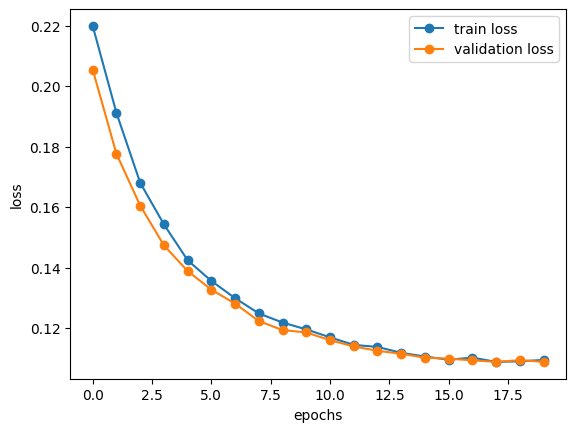

In [8]:
import matplotlib.pyplot as plt

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.00001,
    momentum=0.9,
    weight_decay=0.0001
)

num_epochs = 20

train_loss_list = []
validation_loss_list = []
model.train()
for epoch in range(num_epochs):
    N = len(train_loader.dataset)
    current_train_loss = 0
    # train loop
    for images, targets in train_loader:
        # move data to device and build the right input format for our model
        images = list(image.to(device) for image in images) 
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        current_train_loss += losses
    train_loss_list.append(current_train_loss / N)

    # validation loop
    N = len(validation_loader.dataset)
    current_validation_loss = 0
    with torch.no_grad():
        for images, targets in validation_loader:
            images = list(image.to(device) for image in images) 
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            current_validation_loss += losses
    validation_loss_list.append(current_validation_loss / N)



    print(f"epoch: {epoch}")
    print(f"train loss: {train_loss_list[-1]}, validation loss: {validation_loss_list[-1]}")

torch.save(model, './models/model.pth')

# plot losses
train_loss = [x.cpu().detach().numpy() for x in train_loss_list]
validation_loss = [x.cpu().detach().numpy() for x in validation_loss_list]

plt.plot(train_loss, '-o', label='train loss')
plt.plot(validation_loss, '-o', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

# Inference
use the trained model to predict a bounding box on an image

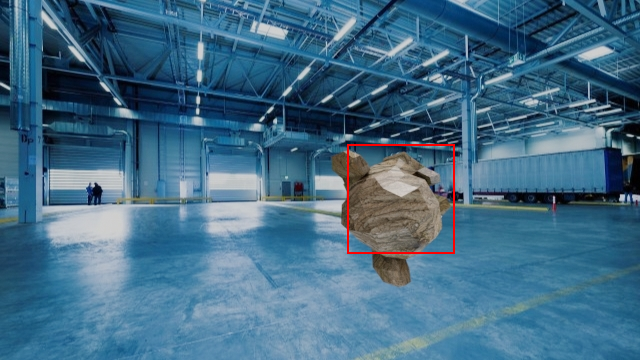

[{'boxes': tensor([[347.5020, 144.5729, 454.6863, 253.4152],
          [319.2943, 160.1207, 432.8298, 297.3530],
          [321.5083, 170.3723, 450.7403, 224.2187],
          [379.9024, 132.5896, 450.1119, 300.8226],
          [314.6429, 148.9530, 433.0893, 210.7644],
          [309.9553, 157.3244, 509.9398, 250.9663],
          [310.0724,  98.1899, 453.0958, 318.9389],
          [337.1865, 204.7847, 450.7348, 311.7841],
          [365.6422, 151.0144, 443.6011, 216.5569],
          [336.8309, 172.5680, 495.2287, 290.5221],
          [269.3260, 142.7982, 453.9576, 233.2860],
          [ 89.3002, 179.1057, 100.1563, 206.6321],
          [403.7120, 163.8624, 451.4429, 268.2796],
          [ 87.1131, 194.5008, 103.1361, 220.5876],
          [620.1021, 117.4962, 640.0000, 136.8728],
          [617.6324, 116.3086, 640.0000, 198.4699],
          [ 88.3333, 183.1373,  96.5944, 201.1779],
          [619.3223, 126.5976, 639.6578, 153.0942],
          [624.2715, 156.4869, 637.3118, 207.0677],
   

In [12]:
img, _ = validation_dataset[random.randint(0,len(training_dataset)-1)]
model = torch.load('./models/model.pth')

def inference(img, device, model):
    model.eval()
    with torch.no_grad():
        pred = model([img.to(device)])

    # display image with bbox
    transform = T.ToPILImage()
    img = transform(img)
    x1, y1, x2, y2 = pred[0]['boxes'].cpu().detach().numpy()[0]
    draw = ImageDraw.Draw(img)
    draw.rectangle([x1, y1, x2, y2], fill=None, outline='#ff0000cc', width=2)
    display(img)
    return pred

inference(img, device, model)